# Principal Component Analysis
Autocorrelation - Orthoginality - Optimization

This notebook describes the basis of Principal Component Analysis, the benefits of using this dimensionality reduction technique, and two approach for solving for the principal components. The first approach uses properties of eigenvectors solved from covariance matrices and the second approach uses similar principles but through an iterative method to arrive at estimated principal components.

Note on terminology: In some contexts, an autocorrelation matrix is called a [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix). They are equivalent if the mean of each feature is 0, but differ otherwise. To confuse matters further, a correlation (but not autocorrelation) is a term that ranges between -1 and 1 and indicates relatedness between 2 features. A correlation matrix consists of correlation terms.

## Setting the scene

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import pandas as pd

In [2]:
filename = 'ObesityData_synthetic.csv'
X = np.loadtxt(filename,delimiter=',',skiprows=1,usecols=[2,3])
y = np.loadtxt(filename,delimiter=',',skiprows=1,usecols=[-1],dtype='str')

From this dataset, we are taking the height and weight features and we can extract a set of ground truth labels. With using numpy directly, we have to be careful when extracting string categorical labels. We can use np.unique to provide numerical encoding. Please do note that you have to give some thought with numerically encoding categorical data. In this case it is ordinal, which gives more credence to our approach.

In [3]:
keys, num_label = np.unique(y, return_inverse=True)

In [4]:
keys

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype='<U19')

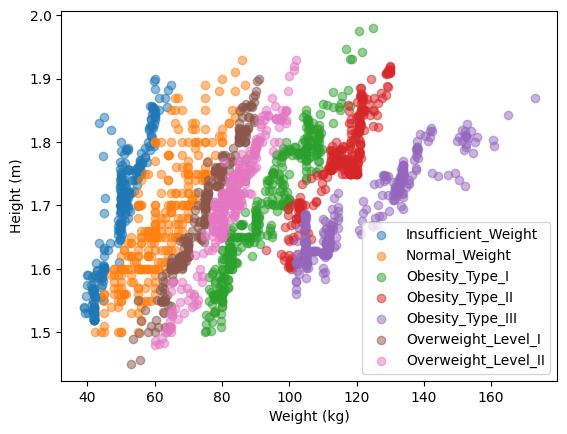

In [5]:
for i in np.arange(len(keys)):
    plt.scatter(X[num_label==i,1],X[num_label==i,0], alpha=0.5)
plt.legend(keys)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (m)")
plt.show()

This data is taken from [kaggle](https://www.kaggle.com/datasets/lesumitkumarroy/obesity-data-set) and describes a data set collected for tracking levels of obesity. We are using it just because height and weight are common measures that we have intuition for. The idea being that the Body Mass Index (BMI) is used as a calculation for obesity. 

$BMI = \frac{weight (kg)}{height (m)^2}$

With higher values of BMI defining higher levels of obesity.

![BMI chart](BMI_chart.png)

In [6]:
BMI = X[:,1] / (np.square(X[:,0]))

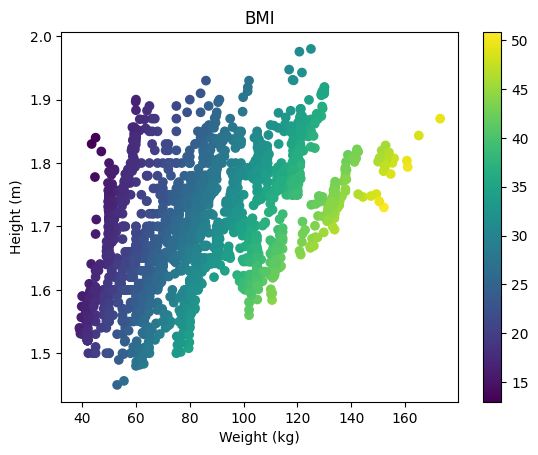

In [7]:
plt.scatter(X[:,1],X[:,0],c=BMI)
plt.colorbar()
plt.xlabel("Weight (kg)")
plt.ylabel("Height (m)")
plt.title('BMI')
plt.show()

In this case we know that BMI defines obesity. 
- "Normal Weight" 18.5 $\leq$ BMI $<$ 24.9
- "Overweight" 25 $\leq$ BMI $<$ 29.9
- "Obese  30 $\leq$ BMI

__Don't get it twisted__, BMI is used for a health metric. BMI captures a non-linear relationship between height and weight. This demo is interested in modelling _linear relationships_ between features.

An analysis of BMI can be interesting, but in this case we are interested in looking at big versus small people (or a linear relationship between these features). We will reframe this problem in that __we want to classify big versus small people__.


# Big versus Small People—Not BMI

To better understand our data it is sometimes useful to consider how one feature may vary with another feature. To do this we can use the measure of autocorrelation. Autocorrelation is related to variance (and standard deviation) but instead of a feature having a bit of self-reflection, it looks at how one measure changes with another.

To do this we can use our friend—the dot product! Remember the dot product examines the relationship between two vectors or points in our space. Large positive values mean that our two vectors are related, large negative numbers mean that our vectors have opposite relationships, and a value of 0 mean that our vectors are not related (or that they _are_ orthogonal).

In [8]:
X.shape

(2111, 2)

In [9]:
autocorrelation = np.matmul(X.T,X) / X.shape[0]
print(autocorrelation)

[[2.90440748e+00 1.48472793e+02]
 [1.48472793e+02 8.18279799e+03]]


Another way to look at what $X^{T}X$ is doing is that we are effectively using each sample as an observation for calculating the feature autocorrelation.

The resulting size is related to the features that we have. It is a symmetric matrix, and it describes the expected value of the product of each feature with itself (on the diagonal, so the expected squared value) and with the other features (off-diagonal).

If we subtract the means from the feature matrix before calculating the above quantity, the result is still symmetric and describes how each feature varies with itself (variances on the diagonal) and with the other features (covariances on the off-diagonal). This is called a covariance matrix.

In [10]:
X_centered = X - np.mean(X,axis=0)
cov = np.matmul(X_centered.T, X_centered) / X.shape[0]
print(cov)

[[8.70166540e-03 1.13125856e+00]
 [1.13125856e+00 6.85652524e+02]]


The variance of height is 8.70e-3 m², which means a standard deviation of 0.0933 m or 9.33 cm.

The variance of weight is 6.86e2 kg², which means a standard deviation of 26.2 kg.

Further, if we __standardize__ the feature matrix, we actually can get to a correlation metric called the correlation matrix!

In [11]:
X_norm = X_centered / np.std(X,axis=0)

In [12]:
correlation = np.matmul(X_norm.T,X_norm) / X.shape[0]
print(correlation)
# The covariance matrix of the normalized features is the correlation matrix
correlation = np.cov(X_norm, rowvar=False, bias=True)
print(correlation)
# NumPy can also calculate this from the original data
correlation = np.corrcoef(X.T)
print(correlation)

[[1.         0.46313612]
 [0.46313612 1.        ]]
[[1.         0.46313612]
 [0.46313612 1.        ]]
[[1.         0.46313612]
 [0.46313612 1.        ]]


The diagonals show that each feature is perfectly correlated with itself (the normalized variable has a variance of 1), and the off-diagonals give us the correlation between features. Correlation is looking at a linear relationship between features.

__Note here:__ We do not see a perfect correlation between height and weight! This is because, as we know from experience, that you can have large people who are short, and small people that are tall—and all sizes in-between.

In [13]:
def generate_points(num_points, dimensions):
    points = []
    while len(points) < num_points:
        batch_size = num_points - len(points)
        candidates = np.random.uniform(-1, 1, (batch_size * 2, dimensions))
        valid_points = candidates[np.linalg.norm(candidates, axis=1) <= 1]
        points.extend(valid_points[:num_points - len(points)])
    return np.array(points)

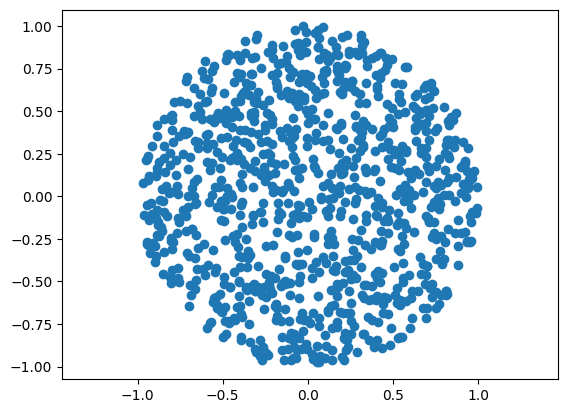

In [14]:
unit_circle_points = generate_points(1000, 2)
plt.scatter(unit_circle_points[:,0],unit_circle_points[:,1])
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.axis('equal')
plt.show()

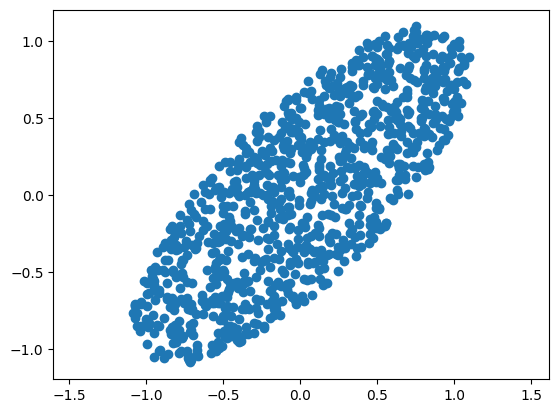

In [15]:
unit_circle_points_transformed = np.dot(unit_circle_points,correlation)
plt.scatter(unit_circle_points_transformed[:,0],unit_circle_points_transformed[:,1])
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.axis('equal')
plt.show()

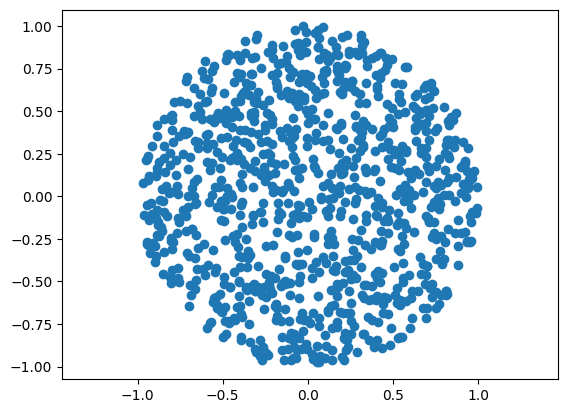

In [16]:
unit_circle_recon = np.dot(unit_circle_points_transformed,np.linalg.inv(correlation))
plt.scatter(unit_circle_recon[:,0],unit_circle_recon[:,1])
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.axis('equal')
plt.show()

If we are interested in looking at big versus small people we could use classification by means of a linear decision boundary. We might choose a normal vector that weights normalized weight and height equally.

$\vec{n} = [1, 1]$

We still need an offset. Using -1 will put (0,1) and (1,0) on the boundary, which seems like a reasonable first guess:

$w_0 ~= -1$

In [17]:
w_0 = -1    
size_label = (X_norm[:,1]*1 + X_norm[:,0]*1 + w_0) > 0
# Note that feature order is 1-0 since we want axes to be weight-height in order

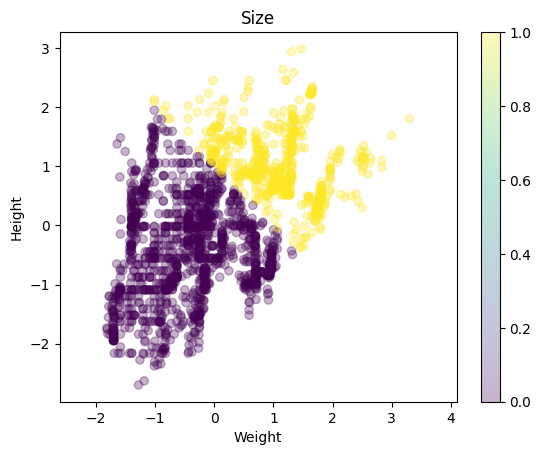

In [18]:
plt.scatter(X_norm[:,1], X_norm[:,0], c=size_label, alpha=0.3)
plt.colorbar()
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title('Size')
plt.axis('equal')
plt.show()

In this case, the dark purple color refers to "small" people and the yellow color observations are "big" people.

# Principal component analysis 
PCA is a unsupervised dimensionality reduction technique that reframes our observations using features that capture the greatest amount of variance in our data. We want to keep the same observations but describe it using _linear combinations_ of our original features. The combinations of features are selected to maximize variance in our new features. This is often useful because the variance describes the separation between our observations.

In this case it may be more handy for us to use a single feature to separate small and big people than a linear combination of two features.

__Note here:__ Our new feature below is just a linear combination of our first two features (exactly what the response of linear regression model is!)

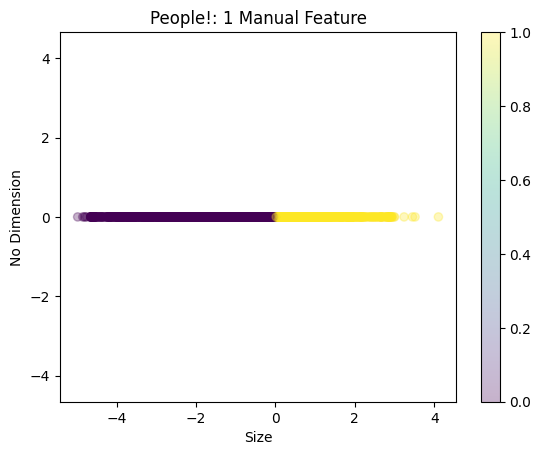

In [19]:
plt.scatter((X_norm[:,1]*1 + X_norm[:,0]*1 + w_0), np.zeros(size_label.shape), c=size_label, alpha=0.3)
plt.colorbar()
plt.xlabel("Size")
plt.ylabel("No Dimension")
plt.title('People!: 1 Manual Feature')
plt.axis('equal')
plt.show()

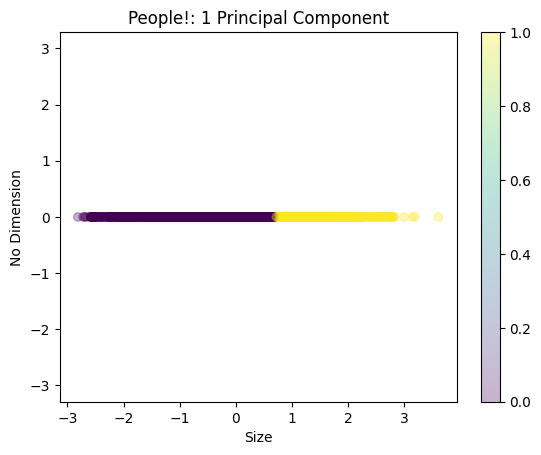

In [20]:
pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
plt.scatter(X_pca[:,0], np.zeros(size_label.shape), c=size_label, alpha=0.3)
plt.colorbar()
plt.xlabel("Size")
plt.ylabel("No Dimension")
plt.title('People!: 1 Principal Component')
plt.axis('equal')
plt.show()

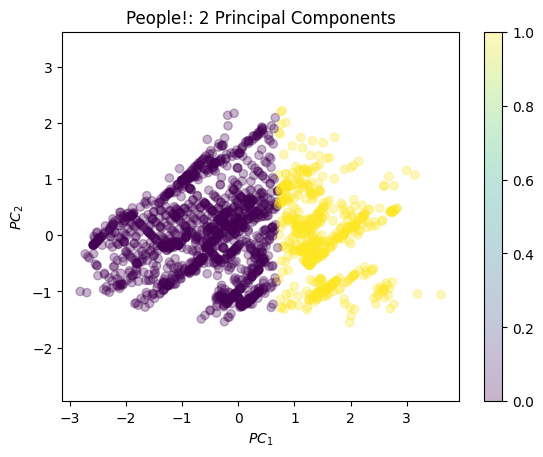

In [21]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=size_label, alpha=0.3)
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.axis('equal')
plt.title('People!: 2 Principal Components')
plt.show()

Note that it is necessary standardize the features to similar scales otherwise PCA will just find that weight explains most of the variance and height very little because of their large difference in scale.

So our goal now is to harness the variance of our data. We want to re-describe our data using features that have as much variance as possible and as little autocorrelation as possible.

__Note here:__ We want correlation between a given feature and a response. This allows us to predict some label given the information that we have. _However,_ it is not useful for us to have correlation between our features. If correlation between features helped us with our predictions then we could just add the same feature as many times as we pleased to improve our predictor's performance.

It should be clear at this point that there might be multiple ways to skin this PCA cat.

1. If we had some device that could find all of these special vectors that maximized within feature variance but enforced between feature orthogonality—that would be dope! 
2. We could conceivably solve for something like a linear regression model line of best fit to our data (like we just did in this simple case). The distinction here is that PCA is an unsupervised approach, and we don't have a response to solve for. The line that we are looking for maximizes the variance of the resulting “features”.

# PCA through Eigen*vectors* and Eigen*values*

In [22]:
eig_val,eig_vec = np.linalg.eig(correlation)
eig_vec

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [23]:
eig_vec.shape

(2, 2)

In [24]:
eig_val

array([1.46313612, 0.53686388])

In [25]:
P_eig = np.matmul(X_norm,eig_vec)

In [26]:
P_eig.shape

(2111, 2)

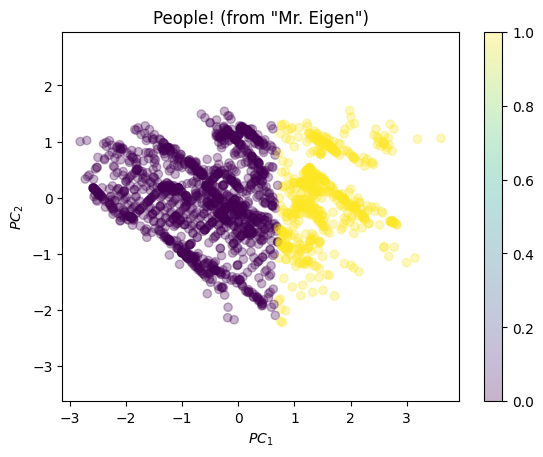

[[ 1.00000000e+00 -1.61563483e-16]
 [-1.61563483e-16  1.00000000e+00]]
[[ 1.00000000e+00 -1.61563483e-16]
 [-1.61563483e-16  1.00000000e+00]]


In [27]:
plt.scatter(P_eig[:,0], P_eig[:,1], c=size_label, alpha=0.3)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('People! (from "Mr. Eigen")')
plt.axis('equal')
plt.show()

scaler = StandardScaler()
pc = scaler.fit_transform(P_eig)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

Note that the eigenvectors will always be $\frac{(\pm 1 ,\pm 1)}{\sqrt{2}}$ when the (normalized) input features have equal variance, as they do here. The principal eigenvector represents a ±45° rotation and represents a rotation of the input to align the direction of maximum variance to the 1st principal component. Note that a sign change of all elements of the eigenvector does not change its structure; it just flips the sign of the projection.

Also, note above that the eigenvalues are 1+|ρ| and 1-|ρ|, where ρ is the correlation. The eigenvalues increase as more variance is explained by an eigenvector. So, when ρ=±1, the 2nd dimension contains no additional information and when ρ=0, the 2nd dimension is completely independent.

# PCA through Iterative Approaches

In [28]:
class customPCA1:
    def __init__(self, X, n_components, alpha=10.0):
        self.X = X
        self.n_components = n_components
        self.alpha = alpha

    def cost(self, W_flat):
        # Reshape the flattened array to the original shape of W
        W = W_flat.reshape(self.X.shape[1], self.n_components)
        
        # Compute the projection onto principal components
        X_proj = np.dot(self.X, W)
        
        # Reconstruct the data using the projected principal components
        X_recon = np.dot(X_proj, W.T)
        
        # Compute the reconstruction error
        reconstruction_error = np.linalg.norm(self.X - X_recon) ** 2
        
        # Orthogonality constraint penalty term
        orthogonality_penalty = np.linalg.norm(np.dot(W.T, W) - np.eye(W.shape[1])) ** 2
        
        # Total cost with orthogonality constraint
        total_cost = reconstruction_error + self.alpha * orthogonality_penalty
        
        return total_cost

    def fit(self):
        # Initialize transformation matrix randomly
        W_init = np.random.rand(self.X.shape[1], self.n_components)
        
        # Flatten the initial guess since the minimize function expects it that way
        W_init_flat = W_init.flatten()
        
        # Minimize the cost function using scipy.optimize.minimize
        result = minimize(self.cost, W_init_flat, method='BFGS')
        
        # Extract the optimal transformation matrix
        W_optimal = result.x.reshape(self.X.shape[1], self.n_components)
        
        return W_optimal

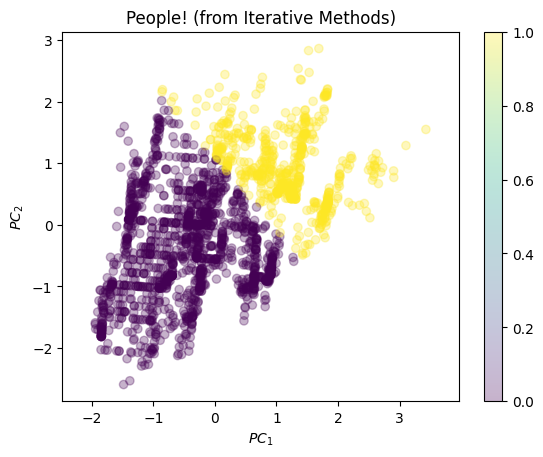

(2111, 2)
[[1.         0.45896058]
 [0.45896058 1.        ]]
[[1.         0.45896058]
 [0.45896058 1.        ]]
[[ 0.07561616  0.99713699]
 [ 0.99713699 -0.07561616]]


In [29]:
pca1 = customPCA1(X_norm, n_components=2,alpha=100)
W_optimal = pca1.fit()
pc = np.dot(X_norm,W_optimal.T)

plt.scatter(pc[:,0], pc[:,1], c=size_label, alpha=0.3)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('People! (from Iterative Methods)')
plt.axis('equal')
plt.show()

scaler = StandardScaler()
pc = scaler.fit_transform(pc)
print(pc.shape)
# Correlation matrix 2 different ways:
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

# Discovered principal components.
print(W_optimal.reshape(2,-1))

Note that the optimizer above did not above did not quite find the theoretical principal components representing 45 degree rotations.

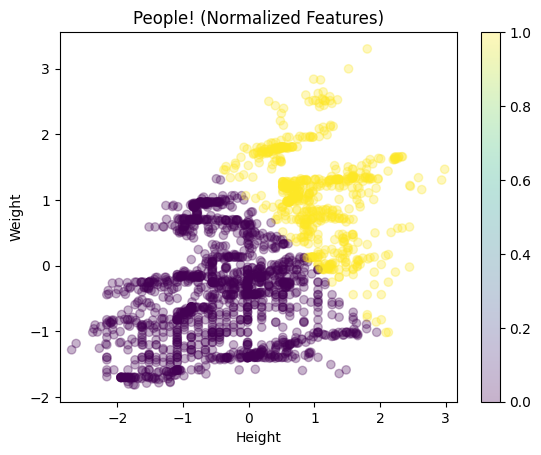

[[1.         0.46313612]
 [0.46313612 1.        ]]
[[1.         0.46313612]
 [0.46313612 1.        ]]


In [30]:
plt.scatter(X_norm[:,0], X_norm[:,1], c=size_label, alpha=0.3)
plt.colorbar()
plt.xlabel("Height")
plt.ylabel("Weight")
plt.title('People! (Normalized Features)')
plt.axis('equal')
plt.show()

scaler = StandardScaler()
pc = scaler.fit_transform(X_norm)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

In [31]:
class customPCA2:
    def __init__(self, X, n_components, alpha=5.0):
        self.X = X
        self.n_components = n_components
        self.alpha = alpha

    def cost(self, W_flat):
        # Reshape the flattened array to the original shape of W
        W = W_flat.reshape(self.X.shape[1], self.n_components)
        
        # Compute the projection onto principal components
        X_proj = np.dot(self.X, W)
        
        cov = np.abs(np.cov(X_proj, rowvar=False, bias=True))
        
        # Note: abs since a negative correlation should still be penalized
        var = np.trace(cov) # total (self-)variance
        covar = np.sum(cov) - var # sum of just the abs(cov) elements
        
        reconstruction_error = np.linalg.norm(self.X - np.dot(X_proj, W.T)) ** 2
        orthogonality_penalty = covar

        return reconstruction_error + self.alpha * orthogonality_penalty

    def fit(self):
        # Initialize transformation matrix randomly
        W_init = np.random.rand(self.X.shape[1], self.n_components)
        
        # Flatten the initial guess
        W_init_flat = W_init.flatten()
        
        # Minimize the cost function using scipy.optimize.minimize
        result = minimize(self.cost, W_init_flat, method='Nelder-Mead')
        
        # Extract the optimal transformation matrix
        W_optimal = result.x.reshape(self.X.shape[1], self.n_components)
        
        return W_optimal

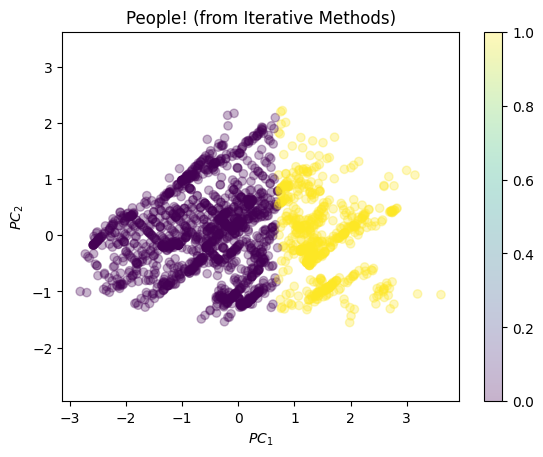

[[ 1.00000000e+00 -4.41313999e-05]
 [-4.41313999e-05  1.00000000e+00]]
[[ 1.00000000e+00 -4.41313999e-05]
 [-4.41313999e-05  1.00000000e+00]]
[[ 0.70709104  0.70712467]
 [ 0.70709703 -0.70712249]]


In [32]:
pca2 = customPCA2(X_norm, n_components=2,alpha=1000)
W_optimal = pca2.fit()
pc = np.dot(X_norm,W_optimal.T)

plt.scatter(pc[:,0], pc[:,1], c=size_label, alpha=0.3)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('People! (from Iterative Methods)')
plt.axis('equal')
plt.show()

scaler = StandardScaler()
pc = scaler.fit_transform(pc)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

print(W_optimal.reshape(2,-1))

This method came closer to finding the optimal solution; it is closer to a 45 degree rotation.

# With higher dimensional data

In [33]:
df, _ = sklearn.datasets.load_iris(as_frame=True, return_X_y=True)
X, y = sklearn.datasets.load_iris(return_X_y=True)
y[y==2]=1 # convert 3 class labels to 2
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

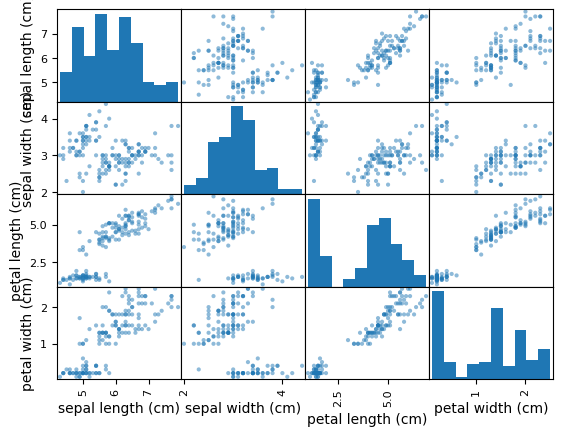

In [34]:
pd.plotting.scatter_matrix(df)
plt.show()

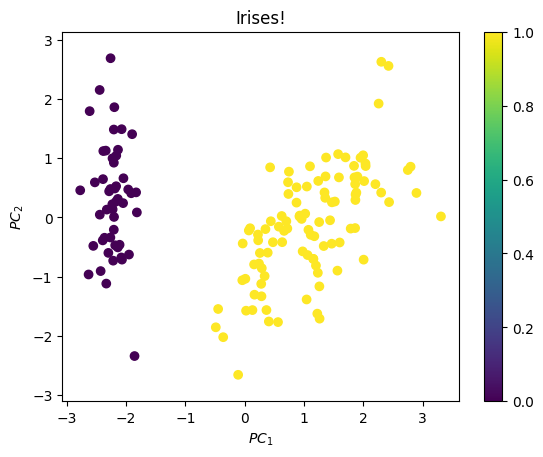

[[ 1.00000000e+00 -1.18423789e-16  1.00364161e-15 -7.28306304e-16]
 [-1.18423789e-16  1.00000000e+00  8.84477676e-17 -1.84741111e-15]
 [ 1.00364161e-15  8.84477676e-17  1.00000000e+00  2.36847579e-17]
 [-7.28306304e-16 -1.84741111e-15  2.36847579e-17  1.00000000e+00]]
[[ 1.00000000e+00 -1.18423789e-16  1.00512191e-15 -7.34227494e-16]
 [-1.18423789e-16  1.00000000e+00  8.84477676e-17 -1.84741111e-15]
 [ 1.00512191e-15  8.84477676e-17  1.00000000e+00  2.36847579e-17]
 [-7.34227494e-16 -1.84741111e-15  2.36847579e-17  1.00000000e+00]]


In [35]:
pca = PCA(4)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)
plt.scatter(X_pca[:,0],X_pca[:,1],c=y)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('Irises!')
plt.axis('equal')
plt.show()

scaler = StandardScaler()
pc = scaler.fit_transform(X_pca)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

Above we confirmed that the projected variables are independent (their feature correlations are virtually 0). Let's look at the found principal components:

In [36]:
print(pca.components_)
print(np.sum(pca.components_**2, axis=0)) # PCA normalizes to length 1 vectors
print(np.dot(pca.components_[:,1], pca.components_[:,3])) # PCs are mutually orthogonal

[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [-0.71956635  0.24438178  0.14212637  0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]
[1. 1. 1. 1.]
-3.0531133177191805e-16


[[ 1.         -0.26849685  0.91701648 -0.10820573]
 [-0.26849685  1.         -0.12383868  0.77891313]
 [ 0.91701648 -0.12383868  1.          0.18796951]
 [-0.10820573  0.77891313  0.18796951  1.        ]]
[[ 1.         -0.26849685  0.91701648 -0.10820573]
 [-0.26849685  1.         -0.12383868  0.77891313]
 [ 0.91701648 -0.12383868  1.          0.18796951]
 [-0.10820573  0.77891313  0.18796951  1.        ]]


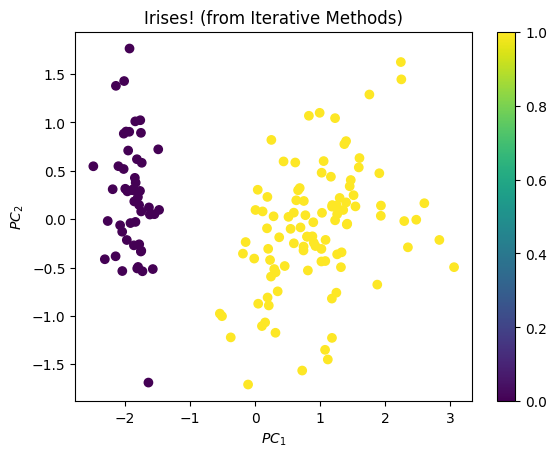

In [37]:
pca1 = customPCA1(X_norm, n_components=4, alpha=1)
W_optimal = pca1.fit()
pc = np.dot(X_norm,W_optimal.T)

plt.scatter(pc[:,0],pc[:,3],c=y)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('Irises! (from Iterative Methods)')

scaler = StandardScaler()
pc = scaler.fit_transform(pc)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))

[[1.         0.94819323 0.75619145 0.59724839]
 [0.94819323 1.         0.54165614 0.68056289]
 [0.75619145 0.54165614 1.         0.02027649]
 [0.59724839 0.68056289 0.02027649 1.        ]]
[[1.         0.94819323 0.75619145 0.59724839]
 [0.94819323 1.         0.54165614 0.68056289]
 [0.75619145 0.54165614 1.         0.02027649]
 [0.59724839 0.68056289 0.02027649 1.        ]]


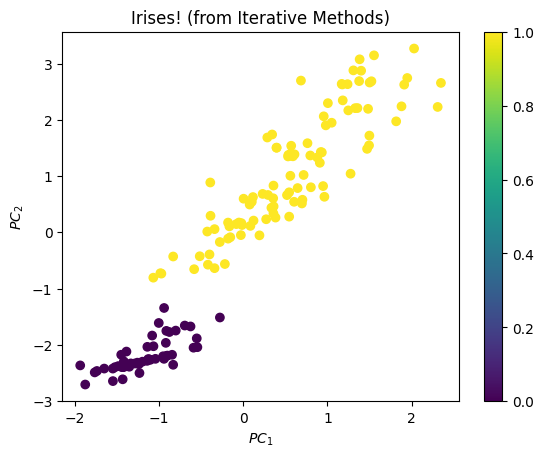

In [38]:
pca2 = customPCA2(X_norm, n_components=4, alpha=100000)
W_optimal = pca2.fit()
pc = np.dot(X_norm,W_optimal.T)

plt.scatter(pc[:,0],pc[:,1],c=y)
    
plt.colorbar()
plt.xlabel("$PC_1$")
plt.ylabel("$PC_2$")
plt.title('Irises! (from Iterative Methods)')

scaler = StandardScaler()
pc = scaler.fit_transform(pc)
print(str((1/(pc.shape[0]) * np.matmul(pc.T,pc))))
print(str(np.cov(pc, rowvar=False, bias=True)))